In [1]:
import sys

sys.path.insert(0, "../simulation")
sys.path.insert(0, "../methods")

import numpy as np
from VAMPClass import VAMP
from AnalyticalMappingEntropyClass import AME
from SimulationClass import Simulation
from TicaTimescalesClass import TICA
from _methods_utils import _mapping_combinations
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15

%matplotlib inline

In [2]:
# Soft Center

kirchoff_matrix = [[ 10,-10,  0,  0], 
                   [-10, 11, -1,  0], 
                   [  0, -1, 11,-10], 
                   [  0,  0,-10, 10]]
# Soft edges

# kirchoff_matrix = [[  1, -1,  0,  0], 
#                    [ -1, 11,-10,  0], 
#                    [  0,-10, 11, -1], 
#                    [  0,  0, -1,  1]]
n_atoms = len(kirchoff_matrix)


In [3]:
n_beads = 2
lagtime = 100

ame = AME(kirchoff_matrix, n_beads = n_beads)
ame.compute_ame()
ame_results = ame.return_ame_scores()
vp_results = ame.return_vp_scores()

vamp = VAMP(kirchoff_matrix, n_beads = n_beads)
vamp.compute_vamp(lagtime)
vamp_results, _ = vamp.return_vamp_scores()

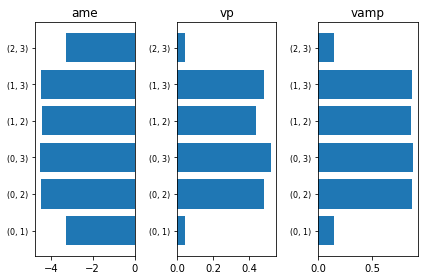

In [4]:
results = [ame_results, vp_results, vamp_results]
titles = ["ame", "vp", "vamp"]
fig, ax = plt.subplots(nrows=1, ncols=len(titles), tight_layout=True)

for ia, aa in enumerate(ax):
    keys = list(results[ia].keys())
    values = results[ia].values()
    y = np.arange(len(values))
    aa.barh(y, values)
    aa.set_yticks(y, keys, fontsize=8, rotation=0)
    aa.set_title(titles[ia])

In [5]:
optimal_mappings = {
    'ame':ame.return_optimal_ame_score()[0],
    'vp':ame.return_optimal_vp_score()[0],
    'vamp':vamp.return_optimal_vamp_score()[0],
}

In [13]:
optimal_mappings

{'ame': (0, 1), 'vp': (0, 3), 'vamp': (0, 3)}

In [14]:
def color_nodes(n_atoms,optimal_mapping):
    colors = n_atoms*['b']
    for ind in optimal_mapping:
        colors[ind] = 'r'
    return colors

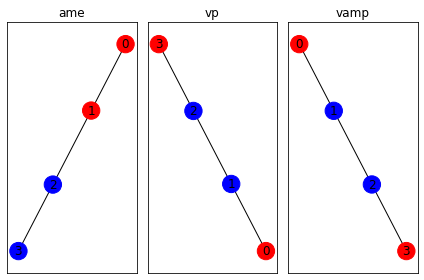

In [15]:
fig,ax = plt.subplots(ncols=len(titles),tight_layout=True)
graph = vamp.graph

for ia,aa in enumerate(ax):
    colors = color_nodes(vamp.n_atoms,optimal_mappings[titles[ia]])
    nx.draw_networkx(graph,node_color=colors,ax=aa)
    aa.set_title(titles[ia])

## TICA Analysis

In [11]:
all_atom_tica = TICA(
    kirchoff_matrix = kirchoff_matrix,
    n_beads = n_atoms,
)

all_atom_mapping_matrix = np.eye(n_atoms)
all_atom_tica.compute_timescale_modes(all_atom_mapping_matrix, lagtime)
all_atom_timescales = all_atom_tica.return_timescales()

In [12]:
# mapping_matrices = _mapping_combinations(n_atoms, n_beads)
vamp_tica = TICA(
    kirchoff_matrix = kirchoff_matrix,
    n_beads = n_beads
)
mapping_matrix = np.zeros((n_beads,n_atoms))
for ii,ind in enumerate(vamp.return_optimal_vamp_score()[0]):
    mapping_matrix[ii,ind] = 1
    
vamp_tica.compute_timescale_modes(mapping_matrix, lagtime)
vamp_timescales = vamp_tica.return_timescales()

In [13]:
ame_tica = TICA(
    kirchoff_matrix = kirchoff_matrix,
    n_beads = n_beads
)
mapping_matrix = np.zeros((n_beads,n_atoms))
for ii,ind in enumerate(ame.return_optimal_ame_score()[0]):
    mapping_matrix[ii,ind] = 1

ame_tica.compute_timescale_modes(mapping_matrix, lagtime)
ame_timescales = ame_tica.return_timescales()

In [14]:
mapping_matrices = _mapping_combinations(n_atoms, n_beads)
vp_tica = TICA(
    kirchoff_matrix = kirchoff_matrix,
    n_beads = n_beads
)
mapping_matrix = np.zeros((n_beads,n_atoms))
for ii,ind in enumerate(ame.return_optimal_vp_score()[0]):
    mapping_matrix[ii,ind] = 1

vp_tica.compute_timescale_modes(mapping_matrix, lagtime)
vp_timescales = vp_tica.return_timescales()

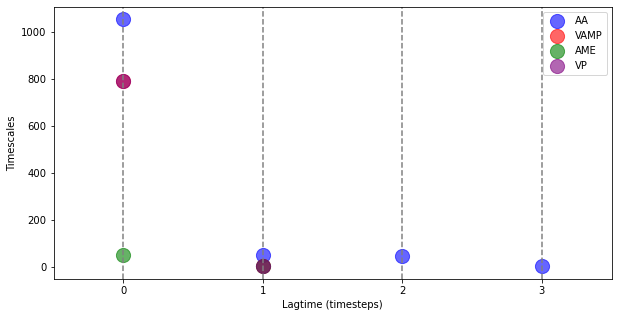

In [16]:
fig,ax = plt.subplots(figsize=(10,5))
xvis = 4
#
x = np.arange(0,len(all_atom_timescales))
ax.scatter(x, all_atom_timescales, s=200, color='blue', alpha=0.6, label='AA')
#
x = np.arange(0,len(vamp_timescales))
ax.scatter(x, vamp_timescales, s=200, color='red', alpha=0.6, label='VAMP')
ax.scatter(x, ame_timescales, s=200, color='green', alpha=0.6, label='AME')
ax.scatter(x, vp_timescales, s=200, color='purple', alpha=0.6, label='VP')
#
for ix in range(xvis):
    ax.axvline(ix,color='gray',linestyle='--')

ax.set_xticks(range(xvis))
ax.set_ylabel('Timescales')
ax.set_xlabel('Lagtime (timesteps)')
ax.set_xlim(-0.5,xvis-0.5)
ax.legend()